<a href="https://colab.research.google.com/github/jgranizo/HackNJIT2024/blob/main/code/Tesla_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
import pandas as pd
import numpy as np
import requests

# Data preprocessing and metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

# Machine learning libraries
import xgboost as xgb
from xgboost import XGBRegressor, XGBClassifier

# Deep learning libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Miscellaneous
import warnings

!pip install ta
import ta
!pip install yfinance
import yfinance as yf

In [ ]:

# Initialize TimeSeries for daily data
data_tesla = yf.download("TSLA", start="2015-10-31", end="2023-10-31", interval='1d')
data_ford = yf.download("F", start="2015-10-31", end="2023-10-31", interval='1d')
data_gm = yf.download("GM", start="2015-10-31", end="2023-10-31", interval='1d')

# Combine and clean data
stock_data = pd.concat([data_tesla['Adj Close'], data_ford['Adj Close'], data_gm['Adj Close']], axis=1)
stock_data.columns = ['Tesla', 'Ford', 'GM']

# Calculate log returns
stock_data['Tesla_Log_Return'] = np.log(stock_data['Tesla'] / stock_data['Tesla'].shift(1))
stock_data['Ford_Log_Return'] = np.log(stock_data['Ford'] / stock_data['Ford'].shift(1))
stock_data['GM_Log_Return'] = np.log(stock_data['GM'] / stock_data['GM'].shift(1))

# Calculate moving averages and volatility
stock_data['Tesla_MA_5'] = stock_data['Tesla'].rolling(window=5).mean()
stock_data['Tesla_MA_20']= stock_data['Tesla'].rolling(window=20).mean()
stock_data['Tesla_MA_50'] = stock_data['Tesla'].rolling(window=50).mean()
stock_data['Tesla_Volatility'] = stock_data['Tesla_Log_Return'].rolling(window=10).std()

stock_data['Ford_MA_5'] = stock_data['Ford'].rolling(window=5).mean()
stock_data['Ford_MA_20'] = stock_data['Ford'].rolling(window=20).mean()
stock_data['Ford_MA_50'] = stock_data['Ford'].rolling(window=50).mean()
stock_data['Ford_Volatility'] = stock_data['Ford_Log_Return'].rolling(window=10).std()

stock_data['GM_MA_5'] = stock_data['GM'].rolling(window=5).mean()
stock_data['GM_MA_20'] = stock_data['GM'].rolling(window=20).mean()
stock_data['GM_MA_50'] = stock_data['GM'].rolling(window=50).mean()
stock_data['GM_Volatility'] = stock_data['GM_Log_Return'].rolling(window=10).std()

# Bollinger Bands
stock_data['Tesla_Bollinger_Upper_5'] = stock_data['Tesla_MA_5'] + 2 * stock_data['Tesla'].rolling(window=5).std()
stock_data['Tesla_Bollinger_Lower_5'] = stock_data['Tesla_MA_5'] - 2 * stock_data['Tesla'].rolling(window=5).std()

stock_data['Ford_Bollinger_Upper_5'] = stock_data['Ford_MA_5'] + 2 * stock_data['Ford'].rolling(window=5).std()
stock_data['Ford_Bollinger_Lower_5'] = stock_data['Ford_MA_5'] - 2 * stock_data['Ford'].rolling(window=5).std()

stock_data['GM_Bollinger_Upper_5'] = stock_data['GM_MA_5'] + 2 * stock_data['GM'].rolling(window=5).std()
stock_data['GM_Bollinger_Lower_5'] = stock_data['GM_MA_5'] - 2 * stock_data['GM'].rolling(window=5).std()

# Longer-term Bollinger Bands using MA_50
stock_data['Tesla_Bollinger_Upper_50'] = stock_data['Tesla_MA_50'] + 2 * stock_data['Tesla'].rolling(window=50).std()
stock_data['Tesla_Bollinger_Lower_50'] = stock_data['Tesla_MA_50'] - 2 * stock_data['Tesla'].rolling(window=50).std()

stock_data['Ford_Bollinger_Upper_50'] = stock_data['Ford_MA_50'] + 2 * stock_data['Ford'].rolling(window=50).std()
stock_data['Ford_Bollinger_Lower_50'] = stock_data['Ford_MA_50'] - 2 * stock_data['Ford'].rolling(window=50).std()

stock_data['GM_Bollinger_Upper_50'] = stock_data['GM_MA_50'] + 2 * stock_data['GM'].rolling(window=50).std()
stock_data['GM_Bollinger_Lower_50'] = stock_data['GM_MA_50'] - 2 * stock_data['GM'].rolling(window=50).std()

# RSI calculation
def calculate_rsi(series, period=14):
    delta = series.diff()
    gain = delta.where(delta > 0, 0).rolling(window=period).mean()
    loss = -delta.where(delta < 0, 0).rolling(window=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

stock_data['Tesla_RSI_5'] = calculate_rsi(stock_data['Tesla'], period=5)
stock_data['Tesla_RSI_50'] = calculate_rsi(stock_data['Tesla'], period=50)

stock_data['Ford_RSI_5'] = calculate_rsi(stock_data['Ford'], period=5)
stock_data['Ford_RSI_50'] = calculate_rsi(stock_data['Ford'], period=50)

stock_data['GM_RSI_5'] = calculate_rsi(stock_data['GM'], period=5)
stock_data['GM_RSI_50'] = calculate_rsi(stock_data['GM'], period=50)

# MACD calculation
stock_data['Tesla_MACD'] = stock_data['Tesla'].ewm(span=12, adjust=False).mean() - stock_data['Tesla'].ewm(span=26, adjust=False).mean()
stock_data['Ford_MACD'] = stock_data['Ford'].ewm(span=12, adjust=False).mean() - stock_data['Ford'].ewm(span=26, adjust=False).mean()
stock_data['GM_MACD'] = stock_data['GM'].ewm(span=12, adjust=False).mean() - stock_data['GM'].ewm(span=26, adjust=False).mean()

# Lagged returns
stock_data['Tesla_Log_Return_Lag1'] = stock_data['Tesla_Log_Return'].shift(1)
stock_data['Tesla_Log_Return_Lag5'] = stock_data['Tesla_Log_Return'].shift(5)

stock_data['Ford_Log_Return_Lag1'] = stock_data['Ford_Log_Return'].shift(1)
stock_data['Ford_Log_Return_Lag5'] = stock_data['Ford_Log_Return'].shift(5)

stock_data['GM_Log_Return_Lag1'] = stock_data['GM_Log_Return'].shift(1)
stock_data['GM_Log_Return_Lag5'] = stock_data['GM_Log_Return'].shift(5)

# Additional moving averages
stock_data['Tesla_MA_100'] = stock_data['Tesla'].rolling(window=100).mean()
stock_data['Tesla_MA_200'] = stock_data['Tesla'].rolling(window=200).mean()

stock_data['Ford_MA_100'] = stock_data['Ford'].rolling(window=100).mean()
stock_data['Ford_MA_200'] = stock_data['Ford'].rolling(window=200).mean()

stock_data['GM_MA_100'] = stock_data['GM'].rolling(window=100).mean()
stock_data['GM_MA_200'] = stock_data['GM'].rolling(window=200).mean()

# Drop NaNs
stock_data.dropna(inplace=True)

# Check for missing values to confirm
print(stock_data.isnull().sum())
print(stock_data.head())


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Tesla                       0
Ford                        0
GM                          0
Tesla_Log_Return            0
Ford_Log_Return             0
GM_Log_Return               0
Tesla_MA_5                  0
Tesla_MA_20                 0
Tesla_MA_50                 0
Tesla_Volatility            0
Ford_MA_5                   0
Ford_MA_20                  0
Ford_MA_50                  0
Ford_Volatility             0
GM_MA_5                     0
GM_MA_20                    0
GM_MA_50                    0
GM_Volatility               0
Tesla_Bollinger_Upper_5     0
Tesla_Bollinger_Lower_5     0
Ford_Bollinger_Upper_5      0
Ford_Bollinger_Lower_5      0
GM_Bollinger_Upper_5        0
GM_Bollinger_Lower_5        0
Tesla_Bollinger_Upper_50    0
Tesla_Bollinger_Lower_50    0
Ford_Bollinger_Upper_50     0
Ford_Bollinger_Lower_50     0
GM_Bollinger_Upper_50       0
GM_Bollinger_Lower_50       0
Tesla_RSI_5                 0
Tesla_RSI_50                0
Ford_RSI_5                  0
Ford_RSI_5

In [ ]:
stock_data

,Tesla,Ford,GM,Tesla_Log_Return,Ford_Log_Return,GM_Log_Return,Tesla_MA_5,Tesla_MA_20,Tesla_MA_50,Tesla_Volatility,...,Ford_Log_Return_Lag1,Ford_Log_Return_Lag5,GM_Log_Return_Lag1,GM_Log_Return_Lag5,Tesla_MA_100,Tesla_MA_200,Ford_MA_100,Ford_MA_200,GM_MA_100,GM_MA_200
Date,,,,,,,,,,,,,,,,,,,,,
2016-08-17 00:00:00+00:00,14.882667,8.234755,26.608042,-0.001656,0.004044,0.004405,14.972800,15.145567,14.708000,0.011646,...,-0.007267,-0.004886,-0.004719,0.005777,15.098513,14.492573,8.605551,8.527265,25.352987,25.781857
2016-08-18 00:00:00+00:00,14.900667,8.194878,26.357414,0.001209,-0.004854,-0.009464,14.954133,15.155600,14.691987,0.008762,...,0.004044,0.004886,0.004405,0.015873,15.094100,14.495813,8.601667,8.521849,25.359270,25.770260
2016-08-19 00:00:00+00:00,15.000000,8.234755,26.591330,0.006644,0.004854,0.008836,14.946000,15.164700,14.686173,0.009296,...,-0.004854,0.001623,-0.009464,-0.005685,15.092840,14.501363,8.597207,8.516442,25.369542,25.758986
2016-08-22 00:00:00+00:00,14.862000,8.214815,26.624748,-0.009243,-0.002424,0.001256,14.910534,15.141100,14.691693,0.008188,...,0.004854,0.008077,0.008836,0.009144,15.088280,14.498463,8.591571,8.511440,25.376519,25.749331
2016-08-23 00:00:00+00:00,14.989333,8.254693,26.649807,0.008531,0.004843,0.000941,14.926933,15.125533,14.700987,0.007434,...,-0.002424,-0.007267,0.001256,-0.004719,15.079780,14.496153,8.588936,8.506888,25.391665,25.739720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-24 00:00:00+00:00,216.520004,10.623936,28.249264,0.020719,-0.007871,-0.022846,220.676001,246.269500,248.037200,0.035287,...,-0.013841,0.009178,-0.014946,0.008942,253.318000,215.697900,12.076724,11.591286,34.464771,34.987433
2023-10-25 00:00:00+00:00,212.419998,10.763845,28.694368,-0.019118,0.013083,0.015633,214.624002,244.865500,247.626400,0.034769,...,-0.007871,-0.024381,-0.022846,-0.028425,253.302500,216.161150,12.070040,11.590711,34.413559,34.954640
2023-10-26 00:00:00+00:00,205.759995,10.586626,28.239372,-0.031855,-0.016601,-0.015984,211.754001,242.834499,247.229599,0.034855,...,0.013083,-0.018901,0.015633,-0.005101,253.184000,216.595700,12.059738,11.588607,34.359276,34.913733


In [ ]:
stock_data.dropna(inplace=True)

In [ ]:
stock_data.shape

(1813, 51)

In [ ]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1813 entries, 2016-08-17 00:00:00+00:00 to 2023-10-30 00:00:00+00:00
Data columns (total 51 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Tesla                     1813 non-null   float64
 1   Ford                      1813 non-null   float64
 2   GM                        1813 non-null   float64
 3   Tesla_Log_Return          1813 non-null   float64
 4   Ford_Log_Return           1813 non-null   float64
 5   GM_Log_Return             1813 non-null   float64
 6   Tesla_MA_5                1813 non-null   float64
 7   Tesla_MA_20               1813 non-null   float64
 8   Tesla_MA_50               1813 non-null   float64
 9   Tesla_Volatility          1813 non-null   float64
 10  Ford_MA_5                 1813 non-null   float64
 11  Ford_MA_20                1813 non-null   float64
 12  Ford_MA_50                1813 non-null   float64
 13  Ford_Volatility

# Fetching Sentiment Data


In [ ]:

api_key = ' 672651d172f8f3.98018730'  # Replace with your actual API key
tickers = ['F', 'GM', 'TSLA']  # Ticker symbols to search for
start_date = '2016-08-17'
end_date = '2023-10-31'
limit = 1000 # Maximum number of articles per request

# Initialize offsets and article lists for each ticker
offset_f = 0
offset_GM = 0
offset_tsla = 0
all_articles_f = []
all_articles_GM = []
all_articles_tsla = []

for ticker in tickers:
    while True:
        # Set offset based on ticker
        if ticker == 'F':
            offset = offset_f
        elif ticker == 'GM':
            offset = offset_GM
        elif ticker == 'TSLA':
            offset = offset_tsla

        url = f'https://eodhd.com/api/news?api_token={api_key}&s={ticker}&from={start_date}&to={end_date}&limit={limit}&offset={offset}'
        response = requests.get(url)

        # Check if the response is successful
        if response.status_code != 200:
            print(f"Error fetching data for {ticker}: Status Code {response.status_code}")
            break

        try:
            articles = response.json()
        except ValueError:
            print("Failed to parse JSON")
            break

        if not articles:
            break  # Exit loop if no more articles are returned

        # Extend the appropriate article list and update offset
        if ticker == 'F':
            all_articles_f.extend(articles)
            offset_f += limit
        elif ticker == 'GM':
            all_articles_GM.extend(articles)
            offset_GM += limit
        elif ticker == 'TSLA':
            all_articles_tsla.extend(articles)
            offset_tsla += limit

# Convert to DataFrames for further processing if articles were collected
articles_df_f = pd.DataFrame(all_articles_f) if all_articles_f else pd.DataFrame()
articles_df_GM = pd.DataFrame(all_articles_GM) if all_articles_GM else pd.DataFrame()
articles_df_tsla = pd.DataFrame(all_articles_tsla) if all_articles_tsla else pd.DataFrame()

# Display the DataFrames for verification
print("Ford (F) Articles DataFrame:")
print(articles_df_f.head())

print("\nRivian (RIVN) Articles DataFrame:")
print(articles_df_GM.head())

print("\nTesla (TSLA) Articles DataFrame:")
print(articles_df_tsla.head())


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.


KeyboardInterrupt



In [ ]:
articles_df_f.shape

In [ ]:
articles_df_f

In [ ]:
articles_df_f.columns

Index(['date', 'title', 'content', 'link', 'symbols', 'tags', 'sentiment'], dtype='object')

In [ ]:
articles_df_GM.shape

(6208, 7)

In [ ]:
articles_df_tsla.shape

(29382, 7)

In [ ]:
import ast

# Example DataFrames - replace these with your actual DataFrames
# articles_df_f, articles_df_GM, articles_df_tsla

# Convert 'sentiment' column from string to dictionary in each DataFrame
def safe_eval(x):
    # Check if x is a string; if so, apply ast.literal_eval, otherwise return x as is
    if isinstance(x, str):
        return ast.literal_eval(x)
    return x

articles_df_f['sentiment'] = articles_df_f['sentiment'].apply(safe_eval)
articles_df_GM['sentiment'] = articles_df_GM['sentiment'].apply(safe_eval)
articles_df_tsla['sentiment'] = articles_df_tsla['sentiment'].apply(safe_eval)

# Extract 'polarity' from 'sentiment' column
articles_df_f['F_polarity'] = articles_df_f['sentiment'].apply(lambda x: x['polarity'] if x else None)
articles_df_GM['GM_polarity'] = articles_df_GM['sentiment'].apply(lambda x: x['polarity'] if x else None)
articles_df_tsla['TSLA_polarity'] = articles_df_tsla['sentiment'].apply(lambda x: x['polarity'] if x else None)

# Select only the 'date' and the new polarity columns
articles_df_f = articles_df_f[['date', 'F_polarity']]
articles_df_GM = articles_df_GM[['date', 'GM_polarity']]
articles_df_tsla = articles_df_tsla[['date', 'TSLA_polarity']]

# Merge the DataFrames on 'date'
merged_df = articles_df_f.merge(articles_df_GM, on='date', how='outer').merge(articles_df_tsla, on='date', how='outer')

# Sort the merged DataFrame by date
merged_df.sort_values(by='date', inplace=True)

# Reset index for cleaner output
merged_df.reset_index(drop=True, inplace=True)



                            date  F_polarity  GM_polarity  TSLA_polarity
0      2016-09-23T10:05:00+00:00         NaN          NaN          0.296
1      2016-10-02T18:14:00+00:00         NaN          NaN          0.612
2      2016-10-07T18:58:00+00:00         NaN          NaN          0.318
3      2016-10-26T20:11:00+00:00         NaN          NaN          0.318
4      2016-11-01T02:13:00+00:00         NaN          NaN          0.318
...                          ...         ...          ...            ...
38628  2023-10-31T21:28:00+00:00         NaN          NaN         -0.153
38629  2023-10-31T21:30:58+00:00      -0.026       -0.026         -0.026
38630  2023-10-31T21:33:00+00:00         NaN        0.103            NaN
38631  2023-10-31T21:42:57+00:00         NaN          NaN          1.000
38632  2023-10-31T22:45:00+00:00         NaN          NaN          0.511

[38633 rows x 4 columns]


<Axes: xlabel='F_polarity', ylabel='Count'>

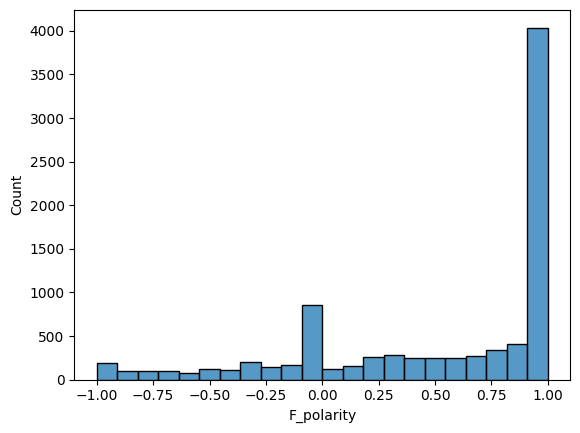

In [ ]:
sns.histplot(merged_df['F_polarity'])

<Axes: xlabel='GM_polarity', ylabel='Count'>

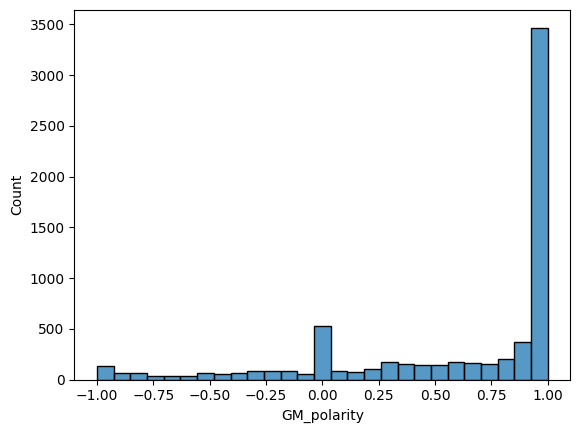

In [ ]:
sns.histplot(merged_df['GM_polarity'])

<Axes: xlabel='TSLA_polarity', ylabel='Count'>

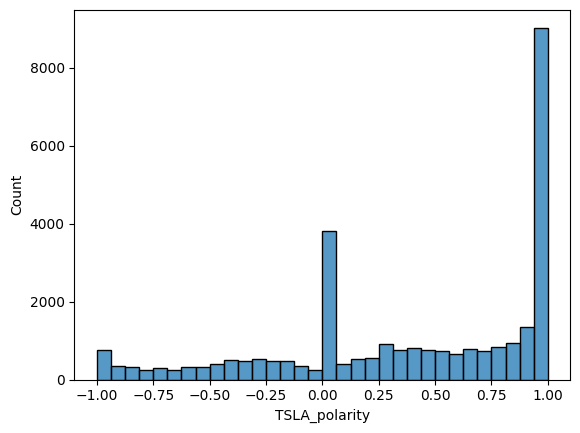

In [ ]:
sns.histplot(merged_df['TSLA_polarity'])

In [ ]:
merged_df['date'] = pd.to_datetime(merged_df['date']).dt.date
daily_polarity = merged_df.groupby('date').median().reset_index()

# Display the final DataFrame
print(daily_polarity)


            date  F_polarity  GM_polarity  TSLA_polarity
0     2016-09-23         NaN          NaN          0.296
1     2016-10-02         NaN          NaN          0.612
2     2016-10-07         NaN          NaN          0.318
3     2016-10-26         NaN          NaN          0.318
4     2016-11-01         NaN          NaN          0.318
...          ...         ...          ...            ...
1334  2023-10-27      0.7350       0.4850          0.732
1335  2023-10-28      0.4915       0.4990          0.077
1336  2023-10-29      0.7580       0.7580          0.395
1337  2023-10-30      0.9320       0.6275          0.492
1338  2023-10-31      0.2500       0.8830          0.250

[1339 rows x 4 columns]


In [ ]:
daily_polarity.isnull().sum()

,0
date,0
F_polarity,335
GM_polarity,328
TSLA_polarity,86


<Axes: xlabel='F_polarity', ylabel='Count'>

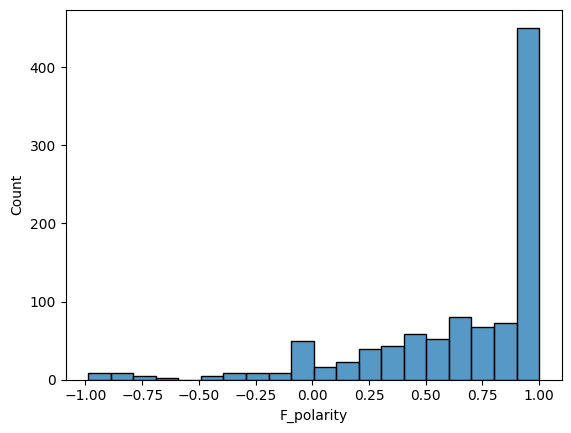

In [ ]:
sns.histplot(daily_polarity['F_polarity'])

In [ ]:
print(daily_polarity['F_polarity'].median())
print(daily_polarity['TSLA_polarity'].median())
print(daily_polarity['GM_polarity'].median())

print(daily_polarity['F_polarity'].mean())
print(daily_polarity['TSLA_polarity'].mean())
print(daily_polarity['GM_polarity'].mean())

print(daily_polarity['F_polarity'].mode())
print(daily_polarity['TSLA_polarity'].mode())
print(daily_polarity['GM_polarity'].mode())
daily_polarity['F_polarity'].value_counts()

0.8345
0.5265
0.918
0.6637176294820718
0.49933439744612923
0.7085173095944608
0    0.0
Name: F_polarity, dtype: float64
0    0.0
Name: TSLA_polarity, dtype: float64
0    0.999
Name: GM_polarity, dtype: float64


,count
F_polarity,
0.0000,44
0.9990,32
0.9980,31
0.9920,19
0.9970,18
...,...
0.6220,1
0.8840,1
-0.1280,1


In [ ]:
daily_polarity['F_polarity'].fillna(daily_polarity['F_polarity'].mean(), inplace=True)
daily_polarity['TSLA_polarity'].fillna(daily_polarity['TSLA_polarity'].mean(), inplace=True)
daily_polarity['GM_polarity'].fillna(daily_polarity['GM_polarity'].mean(), inplace=True)

<ipython-input-69-68d40a659360>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  daily_polarity['F_polarity'].fillna(daily_polarity['F_polarity'].mean(), inplace=True)
<ipython-input-69-68d40a659360>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].

In [ ]:
print(daily_polarity['F_polarity'].mean())
print(daily_polarity['TSLA_polarity'].mean())
print(daily_polarity['GM_polarity'].mean())
daily_polarity.isnull().sum()

daily_polarity.to_csv('/content/drive/MyDrive/KaggleDatasets/XGBoost_models/daily_polarity_ext.csv', index=False)


0.6637176294820718
0.49933439744612934
0.7085173095944608


In [ ]:
daily_polarity = pd.read_csv('/content/drive/MyDrive/KaggleDatasets/XGBoost_models/daily_polarity_ext.csv')

In [ ]:
daily_polarity

,date,F_polarity,GM_polarity,TSLA_polarity
0,2016-09-23,0.663718,0.708517,0.296
1,2016-10-02,0.663718,0.708517,0.612
2,2016-10-07,0.663718,0.708517,0.318
3,2016-10-26,0.663718,0.708517,0.318
4,2016-11-01,0.663718,0.708517,0.318
...,...,...,...,...
1334,2023-10-27,0.735000,0.485000,0.732
1335,2023-10-28,0.491500,0.499000,0.077
1336,2023-10-29,0.758000,0.758000,0.395
1337,2023-10-30,0.932000,0.627500,0.492


In [ ]:
stock_data.head()

NameError: name 'stock_data' is not defined

In [ ]:
stock_data.info()

NameError: name 'stock_data' is not defined

In [ ]:
stock_data['date'] = pd.to_datetime(stock_data.index.date)
stock_data

,Tesla,Ford,GM,Tesla_Log_Return,Ford_Log_Return,GM_Log_Return,Tesla_MA_5,Tesla_MA_20,Tesla_MA_50,Tesla_Volatility,...,Ford_Log_Return_Lag5,GM_Log_Return_Lag1,GM_Log_Return_Lag5,Tesla_MA_100,Tesla_MA_200,Ford_MA_100,Ford_MA_200,GM_MA_100,GM_MA_200,date
Date,,,,,,,,,,,,,,,,,,,,,
2016-08-17 00:00:00+00:00,14.882667,8.234755,26.608036,-0.001656,0.004044,0.004405,14.972800,15.145567,14.708000,0.011646,...,-0.004886,-0.004719,0.005777,15.098513,14.492573,8.605551,8.527265,25.352988,25.781858,2016-08-17
2016-08-18 00:00:00+00:00,14.900667,8.194877,26.357418,0.001209,-0.004854,-0.009464,14.954133,15.155600,14.691987,0.008762,...,0.004886,0.004405,0.015873,15.094100,14.495813,8.601667,8.521848,25.359271,25.770261,2016-08-18
2016-08-19 00:00:00+00:00,15.000000,8.234755,26.591330,0.006644,0.004854,0.008835,14.946000,15.164700,14.686173,0.009296,...,0.001623,-0.009464,-0.005685,15.092840,14.501363,8.597206,8.516442,25.369543,25.758987,2016-08-19
2016-08-22 00:00:00+00:00,14.862000,8.214814,26.624750,-0.009243,-0.002424,0.001256,14.910534,15.141100,14.691693,0.008188,...,0.008077,0.008835,0.009144,15.088280,14.498463,8.591571,8.511440,25.376519,25.749331,2016-08-22
2016-08-23 00:00:00+00:00,14.989333,8.254691,26.649813,0.008531,0.004843,0.000941,14.926933,15.125533,14.700987,0.007434,...,-0.007267,0.001256,-0.004719,15.079780,14.496153,8.588935,8.506888,25.391665,25.739721,2016-08-23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-24 00:00:00+00:00,216.520004,10.623935,28.249264,0.020719,-0.007871,-0.022846,220.676001,246.269500,248.037200,0.035287,...,0.009178,-0.014946,0.008942,253.318000,215.697900,12.076723,11.591286,34.464771,34.987433,2023-10-24
2023-10-25 00:00:00+00:00,212.419998,10.763846,28.694368,-0.019118,0.013084,0.015633,214.624002,244.865500,247.626400,0.034769,...,-0.024381,-0.022846,-0.028425,253.302500,216.161150,12.070040,11.590711,34.413559,34.954640,2023-10-25
2023-10-26 00:00:00+00:00,205.759995,10.586626,28.239372,-0.031855,-0.016601,-0.015984,211.754001,242.834499,247.229599,0.034855,...,-0.018901,0.015633,-0.005101,253.184000,216.595700,12.059738,11.588607,34.359276,34.913733,2023-10-26


In [ ]:
daily_polarity['date'] = pd.to_datetime(daily_polarity['date']).dt.strftime('%Y-%m-%d 00:00:00+00:00')
daily_polarity.set_index('date', inplace=True)
daily_polarity.index = pd.to_datetime(daily_polarity.index)

stock_data['merge_date'] = pd.to_datetime(stock_data.index.date)

# Create a new date-only column in `daily_polarity`
daily_polarity['merge_date'] = pd.to_datetime(daily_polarity.index.date)
merged_df = pd.merge(stock_data.reset_index(drop=True), daily_polarity.reset_index(drop=True), on='merge_date', how='left')

# Drop the temporary `merge_date` column if not needed afterward

# Display the merged DataFrame
print(merged_df.head())

       Tesla      Ford         GM  Tesla_Log_Return  Ford_Log_Return  \
0  14.882667  8.234755  26.608042         -0.001656         0.004044   
1  14.900667  8.194878  26.357414          0.001209        -0.004854   
2  15.000000  8.234755  26.591330          0.006644         0.004854   
3  14.862000  8.214815  26.624748         -0.009243        -0.002424   
4  14.989333  8.254693  26.649807          0.008531         0.004843   

   GM_Log_Return  Tesla_MA_5  Tesla_MA_20  Tesla_MA_50  Tesla_Volatility  ...  \
0       0.004405   14.972800    15.145567    14.708000          0.011646  ...   
1      -0.009464   14.954133    15.155600    14.691987          0.008762  ...   
2       0.008836   14.946000    15.164700    14.686173          0.009296  ...   
3       0.001256   14.910534    15.141100    14.691693          0.008188  ...   
4       0.000941   14.926933    15.125533    14.700987          0.007434  ...   

   Tesla_MA_100  Tesla_MA_200  Ford_MA_100  Ford_MA_200  GM_MA_100  GM_MA_200  \

In [ ]:
merged_df.isnull().sum()

,0
Tesla,0
Ford,0
GM,0
Tesla_Log_Return,0
Ford_Log_Return,0
GM_Log_Return,0
Tesla_MA_5,0
Tesla_MA_20,0
Tesla_MA_50,0
Tesla_Volatility,0


In [ ]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1813 entries, 0 to 1812
Data columns (total 55 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Tesla                     1813 non-null   float64       
 1   Ford                      1813 non-null   float64       
 2   GM                        1813 non-null   float64       
 3   Tesla_Log_Return          1813 non-null   float64       
 4   Ford_Log_Return           1813 non-null   float64       
 5   GM_Log_Return             1813 non-null   float64       
 6   Tesla_MA_5                1813 non-null   float64       
 7   Tesla_MA_20               1813 non-null   float64       
 8   Tesla_MA_50               1813 non-null   float64       
 9   Tesla_Volatility          1813 non-null   float64       
 10  Ford_MA_5                 1813 non-null   float64       
 11  Ford_MA_20                1813 non-null   float64       
 12  Ford_MA_50          

In [ ]:
# Fill missing values in each polarity column with the mean of the respective column
merged_df['F_polarity'] = merged_df['F_polarity'].fillna(merged_df['F_polarity'].mean())
merged_df['TSLA_polarity'] = merged_df['TSLA_polarity'].fillna(merged_df['TSLA_polarity'].mean())
merged_df['GM_polarity'] = merged_df['GM_polarity'].fillna(merged_df['GM_polarity'].mean())


In [ ]:
merged_df['date'] = merged_df['merge_date'].drop(columns=['merge_date'], axis=1)
merged_df.sort_values(by='date', inplace=True)
merged_df

,Tesla,Ford,GM,Tesla_Log_Return,Ford_Log_Return,GM_Log_Return,Tesla_MA_5,Tesla_MA_20,Tesla_MA_50,Tesla_Volatility,...,GM_MA_100,GM_MA_200,merge_date,F_polarity,GM_polarity,TSLA_polarity,date,Tesla_Direction,Ford_Direction,GM_Direction
0,14.882667,8.234755,26.608042,-0.001656,0.004044,0.004405,14.972800,15.145567,14.708000,0.011646,...,25.352987,25.781857,2016-08-17,0.691995,0.722422,0.52123,2016-08-17,0,1,1
1,14.900667,8.194878,26.357414,0.001209,-0.004854,-0.009464,14.954133,15.155600,14.691987,0.008762,...,25.359270,25.770260,2016-08-18,0.691995,0.722422,0.52123,2016-08-18,1,0,0
2,15.000000,8.234755,26.591330,0.006644,0.004854,0.008836,14.946000,15.164700,14.686173,0.009296,...,25.369542,25.758986,2016-08-19,0.691995,0.722422,0.52123,2016-08-19,1,1,1
3,14.862000,8.214815,26.624748,-0.009243,-0.002424,0.001256,14.910534,15.141100,14.691693,0.008188,...,25.376519,25.749331,2016-08-22,0.691995,0.722422,0.52123,2016-08-22,0,0,1
4,14.989333,8.254693,26.649807,0.008531,0.004843,0.000941,14.926933,15.125533,14.700987,0.007434,...,25.391665,25.739720,2016-08-23,0.691995,0.722422,0.52123,2016-08-23,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1808,216.520004,10.623936,28.249264,0.020719,-0.007871,-0.022846,220.676001,246.269500,248.037200,0.035287,...,34.464771,34.987433,2023-10-24,0.998000,0.494000,0.42200,2023-10-24,1,0,0
1809,212.419998,10.763845,28.694368,-0.019118,0.013083,0.015633,214.624002,244.865500,247.626400,0.034769,...,34.413559,34.954640,2023-10-25,0.880000,0.449000,0.86000,2023-10-25,0,1,1
1810,205.759995,10.586626,28.239372,-0.031855,-0.016601,-0.015984,211.754001,242.834499,247.229599,0.034855,...,34.359276,34.913733,2023-10-26,0.815000,0.681000,0.59900,2023-10-26,0,0,0
1811,207.300003,9.290114,26.923843,0.007457,-0.130641,-0.047705,210.816000,240.688499,246.991199,0.035994,...,34.280888,34.862764,2023-10-27,0.735000,0.485000,0.73200,2023-10-27,1,0,0


In [ ]:
merged_df.to_csv('/content/drive/MyDrive/KaggleDatasets/XGBoost_models/big_data_df.csv', index=False)

In [3]:
merged_df = pd.read_csv('/content/drive/MyDrive/KaggleDatasets/XGBoost_models/big_data_df.csv')

In [4]:
merged_df['Tesla_Direction'] = np.where(merged_df['Tesla_Log_Return'] > 0, 1, 0)
merged_df['Ford_Direction'] = np.where(merged_df['Ford_Log_Return'] > 0, 1, 0)
merged_df['GM_Direction'] = np.where(merged_df['GM_Log_Return'] > 0, 1, 0)

test_size = int(len(merged_df) * 0.2)  # e.g., 20% of data for testing
train_data = merged_df[:-test_size]
test_data = merged_df[-test_size:]

In [5]:
train_data

,Tesla,Ford,GM,Tesla_Log_Return,Ford_Log_Return,GM_Log_Return,Tesla_MA_5,Tesla_MA_20,Tesla_MA_50,Tesla_Volatility,...,GM_MA_100,GM_MA_200,merge_date,F_polarity,GM_polarity,TSLA_polarity,date,Tesla_Direction,Ford_Direction,GM_Direction
0,14.882667,8.234755,26.608042,-0.001656,0.004044,0.004405,14.972800,15.145567,14.708000,0.011646,...,25.352987,25.781857,2016-08-17,0.691995,0.722422,0.52123,2016-08-17,0,1,1
1,14.900667,8.194878,26.357414,0.001209,-0.004854,-0.009464,14.954133,15.155600,14.691987,0.008762,...,25.359270,25.770260,2016-08-18,0.691995,0.722422,0.52123,2016-08-18,1,0,0
2,15.000000,8.234755,26.591330,0.006644,0.004854,0.008836,14.946000,15.164700,14.686173,0.009296,...,25.369542,25.758986,2016-08-19,0.691995,0.722422,0.52123,2016-08-19,1,1,1
3,14.862000,8.214815,26.624748,-0.009243,-0.002424,0.001256,14.910534,15.141100,14.691693,0.008188,...,25.376519,25.749331,2016-08-22,0.691995,0.722422,0.52123,2016-08-22,0,0,1
4,14.989333,8.254693,26.649807,0.008531,0.004843,0.000941,14.926933,15.125533,14.700987,0.007434,...,25.391665,25.739720,2016-08-23,0.691995,0.722422,0.52123,2016-08-23,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1446,241.456665,10.962342,36.247421,-0.060556,-0.033902,-0.029480,250.400000,292.837502,310.689934,0.056331,...,46.167102,50.173761,2022-05-16,0.402000,0.420500,0.36200,2022-05-16,0,0,0
1447,253.869995,11.365555,37.224442,0.050132,0.036121,0.026597,247.838000,288.395168,310.403467,0.060313,...,45.991434,50.081286,2022-05-17,0.932000,0.499500,0.00000,2022-05-17,1,1,1
1448,236.603333,10.735535,35.006611,-0.070437,-0.057028,-0.061429,246.225333,283.938667,309.639534,0.057747,...,45.785479,49.973570,2022-05-18,0.966000,0.973000,0.00000,2022-05-18,0,0,0
1449,236.473328,10.794338,35.289944,-0.000550,0.005463,0.008061,244.986664,278.949333,308.642534,0.054557,...,45.577276,49.892477,2022-05-19,0.273000,0.999000,0.03250,2022-05-19,0,1,1


In [6]:
test_data

,Tesla,Ford,GM,Tesla_Log_Return,Ford_Log_Return,GM_Log_Return,Tesla_MA_5,Tesla_MA_20,Tesla_MA_50,Tesla_Volatility,...,GM_MA_100,GM_MA_200,merge_date,F_polarity,GM_polarity,TSLA_polarity,date,Tesla_Direction,Ford_Direction,GM_Direction
1451,224.966660,10.777536,35.172703,0.016433,0.026057,0.016807,234.642664,267.878166,306.676868,0.051947,...,45.157744,49.706404,2022-05-23,0.9915,0.9225,0.2020,2022-05-23,1,1,1
1452,209.386673,10.433127,34.400856,-0.071770,-0.032478,-0.022189,225.745999,263.740499,305.755468,0.053424,...,44.933811,49.614857,2022-05-24,0.9720,0.9990,0.1495,2022-05-24,0,0,0
1453,219.600006,10.676733,35.153152,0.047625,0.023081,0.021633,222.345334,260.028666,304.801535,0.052930,...,44.712516,49.525558,2022-05-25,0.9740,0.3675,0.6210,2022-05-25,1,1,1
1454,235.910004,11.021145,36.560062,0.071643,0.031749,0.039242,222.232669,257.199000,303.918202,0.059037,...,44.480473,49.443244,2022-05-26,0.9980,0.9980,0.6370,2022-05-26,1,1,1
1455,253.210007,11.449557,37.683643,0.070769,0.038135,0.030270,228.614670,255.346834,303.171735,0.060876,...,44.215017,49.364838,2022-05-27,0.7650,0.9770,0.4390,2022-05-27,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1808,216.520004,10.623936,28.249264,0.020719,-0.007871,-0.022846,220.676001,246.269500,248.037200,0.035287,...,34.464771,34.987433,2023-10-24,0.9980,0.4940,0.4220,2023-10-24,1,0,0
1809,212.419998,10.763845,28.694368,-0.019118,0.013083,0.015633,214.624002,244.865500,247.626400,0.034769,...,34.413559,34.954640,2023-10-25,0.8800,0.4490,0.8600,2023-10-25,0,1,1
1810,205.759995,10.586626,28.239372,-0.031855,-0.016601,-0.015984,211.754001,242.834499,247.229599,0.034855,...,34.359276,34.913733,2023-10-26,0.8150,0.6810,0.5990,2023-10-26,0,0,0
1811,207.300003,9.290114,26.923843,0.007457,-0.130641,-0.047705,210.816000,240.688499,246.991199,0.035994,...,34.280888,34.862764,2023-10-27,0.7350,0.4850,0.7320,2023-10-27,1,0,0


In [ ]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1813 entries, 0 to 1812
Data columns (total 59 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Tesla                     1813 non-null   float64       
 1   Ford                      1813 non-null   float64       
 2   GM                        1813 non-null   float64       
 3   Tesla_Log_Return          1813 non-null   float64       
 4   Ford_Log_Return           1813 non-null   float64       
 5   GM_Log_Return             1813 non-null   float64       
 6   Tesla_MA_5                1813 non-null   float64       
 7   Tesla_MA_20               1813 non-null   float64       
 8   Tesla_MA_50               1813 non-null   float64       
 9   Tesla_Volatility          1813 non-null   float64       
 10  Ford_MA_5                 1813 non-null   float64       
 11  Ford_MA_20                1813 non-null   float64       
 12  Ford_MA_50          

In [62]:
# List of columns to exclude to prevent data leakage
exclude_columns = [
    'Tesla_Log_Return', 'Ford_Log_Return', 'GM_Log_Return',
    'Tesla_Direction', 'Ford_Direction', 'GM_Direction',
    'Tesla', 'Ford', 'GM',
    'merge_date', 'date'
]

# Features that are acceptable for X
X_features = [
    col for col in merged_df.columns
    if col not in exclude_columns
]

# Extract X and y
X = merged_df[X_features]
y = merged_df['Tesla_Direction']
y_reg = merged_df['Tesla_Log_Return']

<ipython-input-72-9bfb583b181e>:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


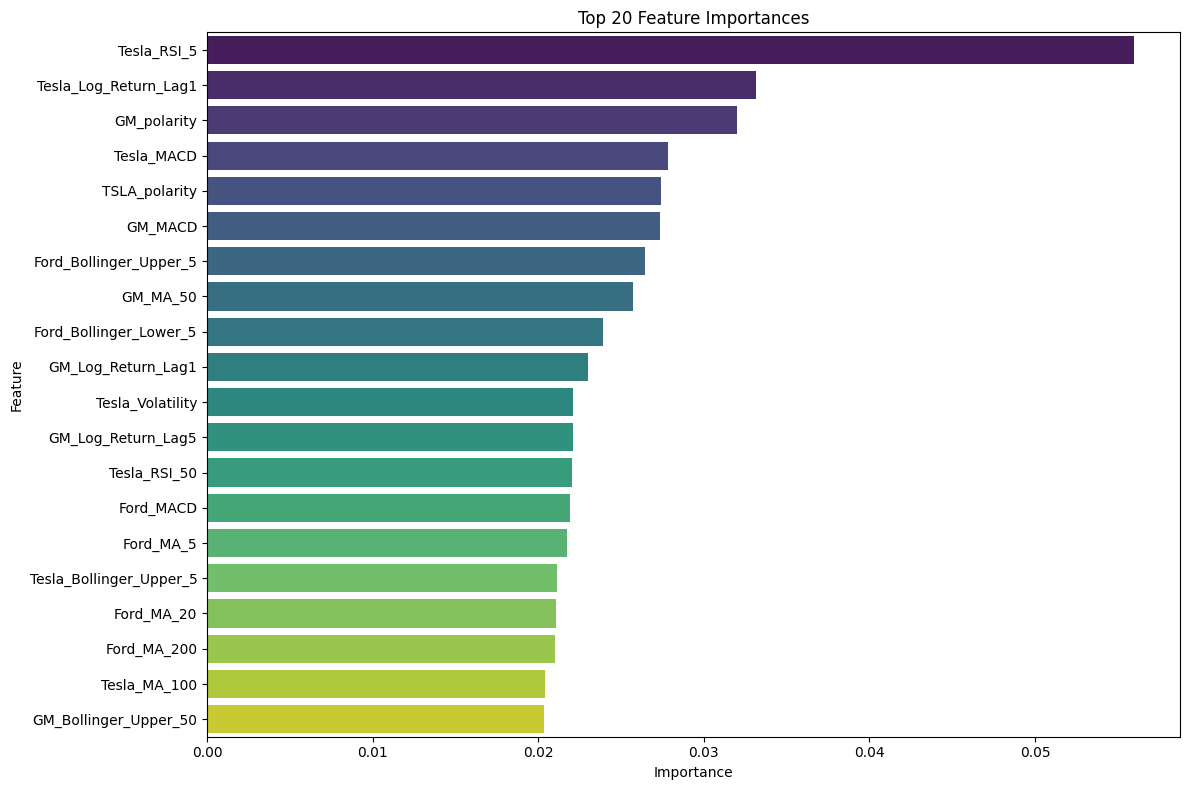

In [72]:



# Define the test size (e.g., 20% of the data)
test_size = int(len(X) * 0.2)  # Adjust the percentage as needed

# Split the data
X_train = X[:-test_size]
X_test = X[-test_size:]
y_train = y[:-test_size]
y_test = y[-test_size:]

y_train_reg = y_reg[:-test_size]
y_test_reg = y_reg[-test_size:]

# Reset indices (optional but can be helpful)
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

# Standardize the features after splitting to avoid data leakage
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data
X_test_scaled = scaler.transform(X_test)

# Convert scaled data back to DataFrame for consistency
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Initialize the XGBoost Classifier
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    n_estimators=100,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

# Fit the model on the training data
xgb_model.fit(X_train_scaled, y_train)

# Predict on the test set (optional)
y_pred = xgb_model.predict(X_test_scaled)

# Get feature importances
importances = xgb_model.feature_importances_
feature_names = X_train.columns

# Create a DataFrame for feature importances
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Visualize the top 20 features
plt.figure(figsize=(12, 8))
sns.barplot(
    x='Importance',
    y='Feature',
    data=feature_importance_df.head(20),
    palette='viridis'
)
plt.title('Top 20 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


# Feature Importance Extraction

we will look at the 30 most important features and features that contribute 90% of the importance

In [73]:

# Get feature importances
importances = xgb_model.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)


### Cumulative Importance

In [74]:
feature_importance_df['Cumulative_Importance'] = feature_importance_df['Importance'].cumsum()
threshold = 0.9
features_to_keep = feature_importance_df[feature_importance_df['Cumulative_Importance'] <= threshold]['Feature']


In [75]:
features_to_keep.count()

40

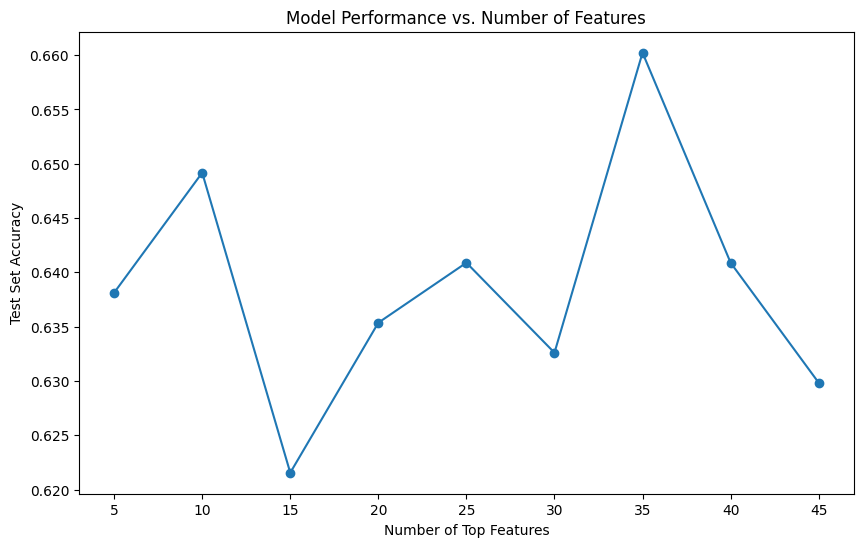

In [76]:

# Suppress any potential XGBoost warnings
warnings.filterwarnings('ignore', category=UserWarning)

# Initialize list to store accuracy scores
accuracy_scores = []

# Define range for number of features to test
num_features_list = range(5, len(feature_importance_df), 5)

# Convert X_train_scaled and X_test_scaled to DataFrames if not already
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=feature_importance_df['Feature'])
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=feature_importance_df['Feature'])

# Iterate over different numbers of top features
for num_features in num_features_list:
    # Get top features based on feature importance
    top_features = feature_importance_df['Feature'][:num_features].values

    # Select top features from the training and testing sets
    X_train_subset = X_train_scaled_df[top_features].values
    X_test_subset = X_test_scaled_df[top_features].values

    # Initialize and train the XGBoost model
    xgb_model = xgb.XGBClassifier(
        objective='binary:logistic',
        n_estimators=100,
        random_state=42,
        use_label_encoder=False,
        eval_metric='logloss'
    )
    xgb_model.fit(X_train_subset, y_train)

    # Make predictions and calculate accuracy
    y_pred = xgb_model.predict(X_test_subset)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)

# Plot accuracy vs. number of features
plt.figure(figsize=(10, 6))
plt.plot(num_features_list, accuracy_scores, marker='o')
plt.xlabel('Number of Top Features')
plt.ylabel('Test Set Accuracy')
plt.title('Model Performance vs. Number of Features')
plt.show()


we can see that the optimal number of fearures to get the highest possible accuracy without ovverfiiting is 35

Random Search

In [77]:
optimal_num_features = 35

# Get the top features based on importance
selected_features = feature_importance_df['Feature'][:optimal_num_features]

# Update the training and testing data
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]


In [78]:
# Re-initialize the scaler
scaler = StandardScaler()
X_train_scaled_selected = scaler.fit_transform(X_train_selected)
X_test_scaled_selected = scaler.transform(X_test_selected)
X_train_scaled_selected.shape

(1451, 35)

In [79]:
# Import necessary libraries


# List of columns to exclude to prevent data leakage

X_features = [
    col for col in merged_df.columns
    if col not in exclude_columns
]


#
# Feature scaling

# Split the data into training and testing sets using time-based split
X_train = X_train_scaled_selected
X_test = X_test_scaled_selected
y_train = y_train_reg
y_test = y_test_reg

# Reset indices (optional)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)


In [65]:
print(y_train.shape)
print(y_test.shape)

(1451,)
(362,)


In [80]:
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
import xgboost as xgb

# Define TimeSeriesSplit object
tscv = TimeSeriesSplit(n_splits=5)

# Initialize the XGBoost Regressor with GPU support
xgb_regressor = xgb.XGBRegressor(
    tree_method='gpu_hist',
    predictor='gpu_predictor',
    random_state=42,
    objective='reg:squarederror',
    eval_metric='rmse'
)

# Define an extensive parameter grid for RandomizedSearchCV
param_grid = {
    'n_estimators': [100, 200, 250, 300, 500],             # Extended around previous best n_estimators
    'max_depth': [3, 4, 5, 6, 8],                          # Broad range around max_depth
    'learning_rate': [0.005, 0.01, 0.02, 0.03, 0.05, 0.1], # Extended around learning_rate
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],               # Wide range around subsample
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],        # Wide range around colsample_bytree
    'reg_alpha': [0, 0.05, 0.1, 0.2],                     # Expanded around reg_alpha
    'reg_lambda': [1, 5, 10, 15],                         # Broad range around reg_lambda
    'gamma': [0, 0.05, 0.1, 0.2]                          # Expanded lower gamma values
}

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_regressor,
    param_distributions=param_grid,
    n_iter=100,  # Number of random combinations to try; adjust for computational resources
    cv=tscv,
    scoring='neg_mean_squared_error',  # Negative MSE for regression
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit the model using RandomizedSearchCV
random_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best parameters found: ", random_search.best_params_)
print("Best cross-validation score (negative MSE): ", random_search.best_score_)

# Initialize the model with the best parameters from RandomizedSearchCV
best_params = random_search.best_params_
best_model = xgb.XGBRegressor(
    **best_params,
    tree_method='gpu_hist',
    predictor='gpu_predictor',
    random_state=42,
    objective='reg:squarederror',
    early_stopping_rounds=15,

    eval_metric='rmse'
)

# Split the training data to use a validation set for early stopping
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

# Fit the model with early stopping



Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters found:  {'subsample': 0.9, 'reg_lambda': 10, 'reg_alpha': 0.05, 'n_estimators': 250, 'max_depth': 3, 'learning_rate': 0.03, 'gamma': 0, 'colsample_bytree': 1.0}
Best cross-validation score (negative MSE):  -0.0013172646041891994


In [81]:
# Fit the model with early stopping
best_model.fit(
    X_train_split, y_train_split,
    eval_set=[(X_val_split, y_val_split)],
    verbose=1
)

# Display final parameters and performance
print("Best model parameters:", best_params)
print("Final validation score (RMSE):", best_model.best_score if hasattr(best_model, "best_score") else "Not available")


[0]	validation_0-rmse:0.03580
[1]	validation_0-rmse:0.03566
[2]	validation_0-rmse:0.03554
[3]	validation_0-rmse:0.03544
[4]	validation_0-rmse:0.03532
[5]	validation_0-rmse:0.03522
[6]	validation_0-rmse:0.03513
[7]	validation_0-rmse:0.03502
[8]	validation_0-rmse:0.03489
[9]	validation_0-rmse:0.03481
[10]	validation_0-rmse:0.03474
[11]	validation_0-rmse:0.03463
[12]	validation_0-rmse:0.03454
[13]	validation_0-rmse:0.03445
[14]	validation_0-rmse:0.03440
[15]	validation_0-rmse:0.03432
[16]	validation_0-rmse:0.03424
[17]	validation_0-rmse:0.03419
[18]	validation_0-rmse:0.03417
[19]	validation_0-rmse:0.03413
[20]	validation_0-rmse:0.03405
[21]	validation_0-rmse:0.03404
[22]	validation_0-rmse:0.03396
[23]	validation_0-rmse:0.03391
[24]	validation_0-rmse:0.03387
[25]	validation_0-rmse:0.03383
[26]	validation_0-rmse:0.03384
[27]	validation_0-rmse:0.03381
[28]	validation_0-rmse:0.03380
[29]	validation_0-rmse:0.03376
[30]	validation_0-rmse:0.03372
[31]	validation_0-rmse:0.03370
[32]	validation_0-

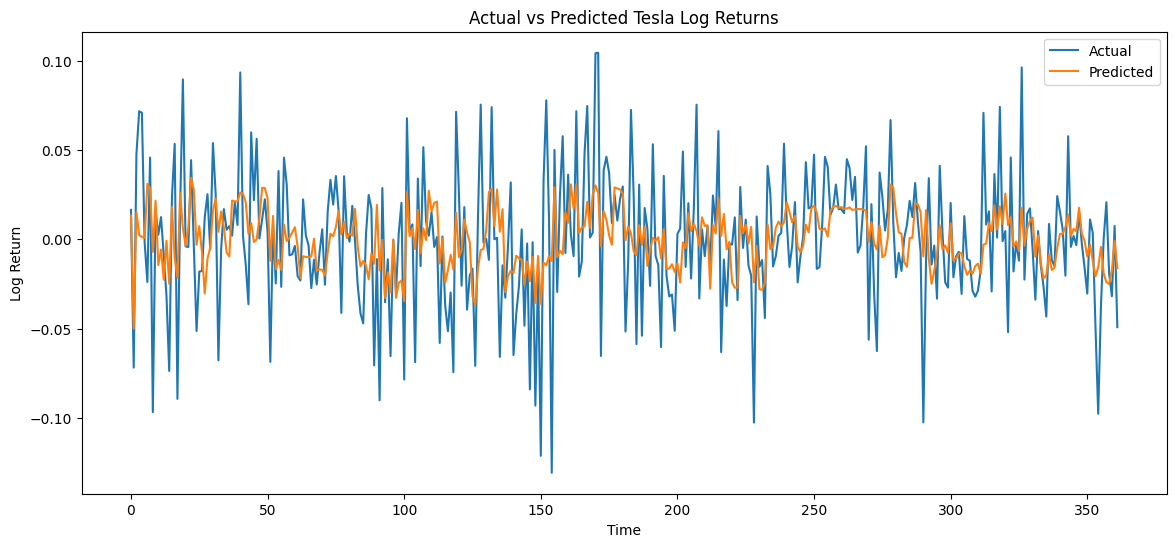

In [82]:





# Test set prediction and evaluation
predictions = best_model.predict(X_test)

# Calculate regression metrics
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

plt.figure(figsize=(14, 6))  # Adjust the width and height as needed
plt.plot(y_test, label='Actual')
plt.plot(predictions, label='Predicted')
plt.xlabel("Time")
plt.ylabel("Log Return")
plt.title("Actual vs Predicted Tesla Log Returns")
plt.legend()
plt.show()


In [83]:
print("Regression Metrics:")
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R² Score: {r2}")

Regression Metrics:
MAE: 0.02482501498364253
MSE: 0.0010465988543078484
RMSE: 0.03235118010688093
R² Score: 0.25970647376111056


In [84]:
y_train_reg

,Tesla_Log_Return
0,-0.001656
1,0.001209
2,0.006644
3,-0.009243
4,0.008531
...,...
1446,-0.060556
1447,0.050132
1448,-0.070437
1449,-0.000550


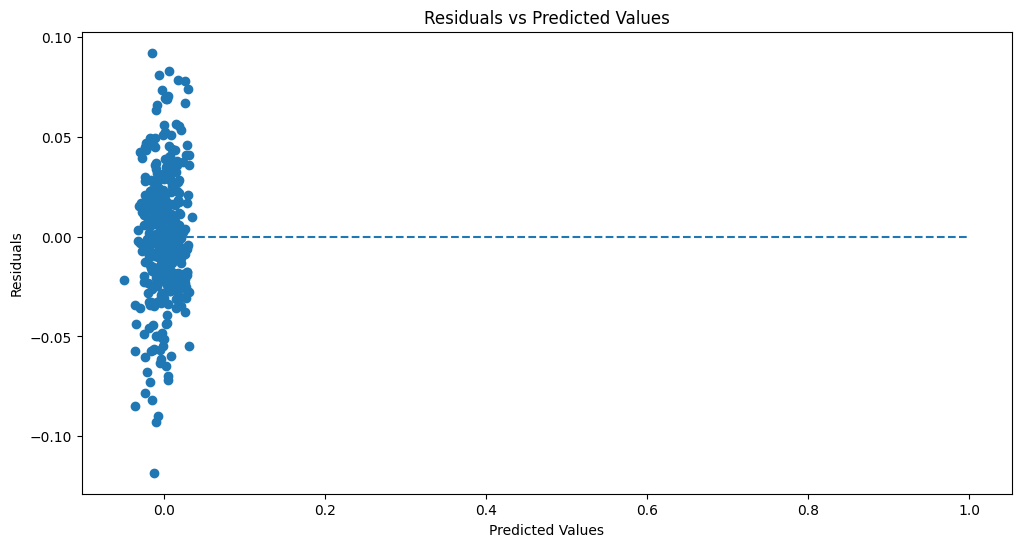

In [85]:
residuals = y_test - predictions

plt.figure(figsize=(12, 6))
plt.scatter(predictions, residuals)
plt.hlines(y=0, xmin=y_pred.min(), xmax=y_pred.max(), linestyles='dashed')
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()


In [ ]:
# Extract X and y for classification
X_class = merged_df[X_features]
y_class = merged_df['Tesla_Direction']  # Target variable for classification

# Handle missing values
X_class.fillna(method='ffill', inplace=True)
X_class.fillna(method='bfill', inplace=True)
y_class.fillna(method='ffill', inplace=True)
y_class.fillna(method='bfill', inplace=True)

# Feature scaling
X_class_scaled = scaler.fit_transform(X_class)

# Split the data into training and testing sets using time-based split
X_train_class = X_class_scaled[:-test_size]
X_test_class = X_class_scaled[-test_size:]
y_train_class = y_class[:-test_size]
y_test_class = y_class[-test_size:]

# Reset indices
y_train_class = y_train_class.reset_index(drop=True)
y_test_class = y_test_class.reset_index(drop=True)


<ipython-input-29-b218d8c41b17>:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_class.fillna(method='ffill', inplace=True)
<ipython-input-29-b218d8c41b17>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_class.fillna(method='ffill', inplace=True)
<ipython-input-29-b218d8c41b17>:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_class.fillna(method='bfill', inplace=True)
<ipython-input-29-b218d8c41b17>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

In [ ]:
# Initialize the XGBoost Classifier
xgb_classifier = xgb.XGBClassifier(
    tree_method='gpu_hist',
    predictor='gpu_predictor',
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

# Define parameter grid for GridSearchCV
param_grid_class = {
    'n_estimators': [ 250,500],
    'max_depth': [2, 5, 7],
    'learning_rate': [0.005, 0.05, 0.1],
    'subsample': [ 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [1, 5],
    'gamma': [0, 0.1, 0.3]
}

# Set up GridSearchCV
grid_search_class = GridSearchCV(
    estimator=xgb_classifier,
    param_grid=param_grid_class,
    cv=tscv,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

# Fit the model using GridSearchCV
grid_search_class.fit(X_train_class, y_train_class)

# Print the best parameters and best score
print("Best parameters found: ", grid_search_class.best_params_)
print("Best cross-validation score: ", grid_search_class.best_score_)


Fitting 5 folds for each of 1296 candidates, totalling 6480 fits
Best parameters found:  {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.005, 'max_depth': 2, 'n_estimators': 500, 'reg_alpha': 0.1, 'reg_lambda': 1, 'subsample': 0.8}
Best cross-validation score:  0.6531120331950209


In [ ]:
# Initialize the model with the best parameters
best_params_class = grid_search_class.best_params_
best_classifier = xgb.XGBClassifier(
    **best_params_class,
    tree_method='gpu_hist',
    predictor='gpu_predictor',
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

# Fit the model on the entire training data
best_classifier.fit(X_train_class, y_train_class)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.005, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=2,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_parallel_tree=None, predictor='gpu_predictor', ...)

In [ ]:
# Predict on the test set
y_pred_class = best_classifier.predict(X_test_class)

# Classification Report

print("Classification Report:")
print(classification_report(y_test_class, y_pred_class))

# Confusion Matrix
conf_mat = confusion_matrix(y_test_class, y_pred_class)
print("Confusion Matrix:")
print(conf_mat)

# Accuracy Score
accuracy = accuracy_score(y_test_class, y_pred_class)
print(f"Test Accuracy: {accuracy}")


Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.71      0.68       175
           1       0.71      0.65      0.68       187

    accuracy                           0.68       362
   macro avg       0.68      0.68      0.68       362
weighted avg       0.68      0.68      0.68       362

Confusion Matrix:
[[125  50]
 [ 66 121]]
Test Accuracy: 0.6795580110497238


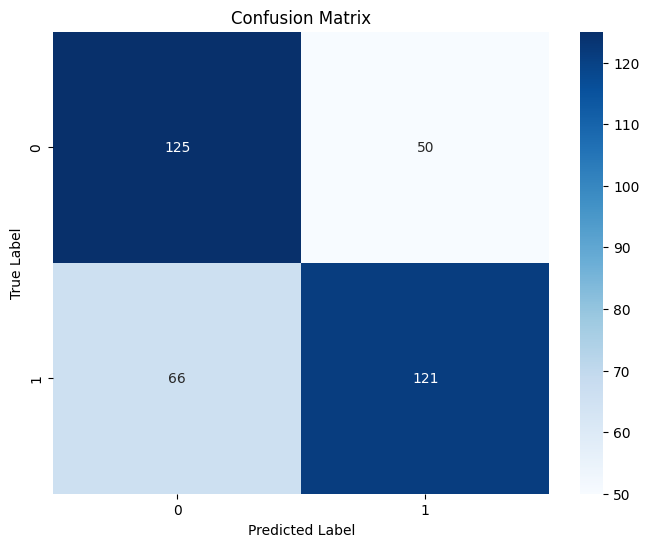

In [ ]:

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


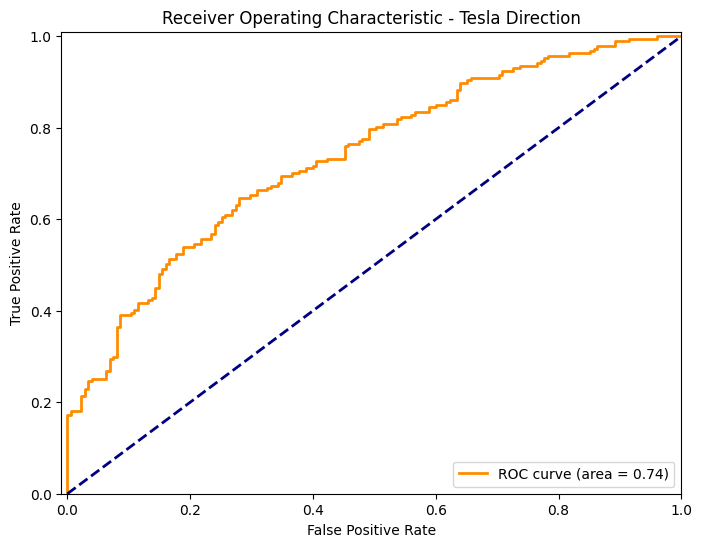

In [ ]:

# Predict probabilities
y_pred_prob = best_classifier.predict_proba(X_test_class)[:, 1]

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test_class, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.01, 1.00])
plt.ylim([0.00, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Tesla Direction')
plt.legend(loc='lower right')
plt.show()


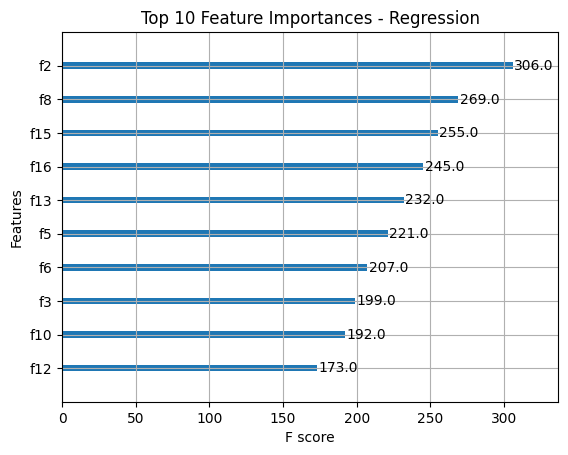

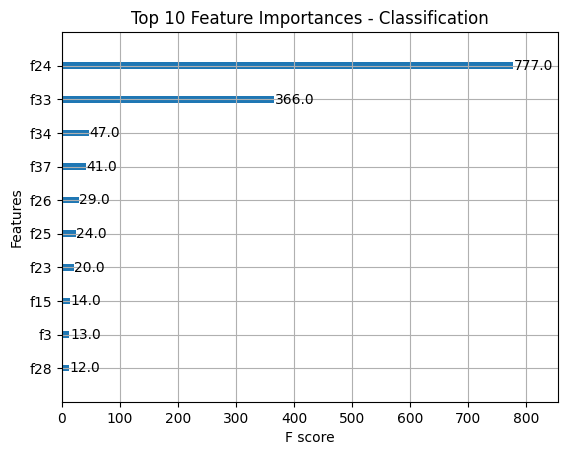

In [ ]:
# For Regression Model
xgb.plot_importance(best_model, max_num_features=10)
plt.title('Top 10 Feature Importances - Regression')
plt.show()

# For Classification Model
xgb.plot_importance(best_classifier, max_num_features=10)
plt.title('Top 10 Feature Importances - Classification')
plt.show()


LSTM model approach

In [ ]:

# Assume 'merged_df' is your DataFrame
# Exclude columns to prevent data leakage
exclude_columns = [
    'Tesla_Log_Return', 'Ford_Log_Return', 'GM_Log_Return',
    'Tesla_Direction', 'Ford_Direction', 'GM_Direction',
    'Tesla', 'Ford', 'GM',
    'merge_date', 'date'
]

# Features for X
X_features = [
    col for col in merged_df.columns
    if col not in exclude_columns
]

# Target variable
y_feature = 'Tesla_Log_Return'  # For regression

# Extract X and y
X = merged_df[X_features]
y = merged_df[y_feature]

# Handle missing values
X.fillna(method='ffill', inplace=True)
X.fillna(method='bfill', inplace=True)
y.fillna(method='ffill', inplace=True)
y.fillna(method='bfill', inplace=True)

# Feature scaling
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# Convert to NumPy arrays
X_scaled = X_scaled.astype(np.float32)
y_scaled = y_scaled.astype(np.float32)

# Split the data into training and testing sets (time-based split)
test_size = int(len(X_scaled) * 0.2)
X_train = X_scaled[:-test_size]
X_test = X_scaled[-test_size:]
y_train = y_scaled[:-test_size]
y_test = y_scaled[-test_size:]

# Define the number of timesteps (window size)
timesteps = 50 # Adjust based on experimentation

def create_sequences(X, y, timesteps):
    Xs, ys = [], []
    for i in range(len(X) - timesteps):
        Xs.append(X[i:(i + timesteps)])
        ys.append(y[i + timesteps])
    return np.array(Xs), np.array(ys)

# Create sequences
X_train_seq, y_train_seq = create_sequences(X_train, y_train, timesteps)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, timesteps)

print(f"Shape of X_train_seq: {X_train_seq.shape}")
print(f"Shape of y_train_seq: {y_train_seq.shape}")
print(f"Shape of X_test_seq: {X_test_seq.shape}")
print(f"Shape of y_test_seq: {y_test_seq.shape}")

# Adjust input shape variables
num_features = X_train_seq.shape[2]

# Define the model
model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(timesteps, num_features)))
model.add(Dropout(0.2))
model.add(LSTM(units=32))
model.add(Dropout(0.2))
model.add(Dense(1))  # Output layer for regression

# Compile the model
model.compile(
    loss='mean_squared_error',
    optimizer=Adam(learning_rate=0.001)
)

model.summary()

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    X_train_seq, y_train_seq,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stopping],
    verbose=1
)

# Make predictions
y_pred_scaled = model.predict(X_test_seq)

# Inverse transform predictions and actual values
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_actual = scaler_y.inverse_transform(y_test_seq)

# Evaluate the model
mse = mean_squared_error(y_test_actual, y_pred)
mae = mean_absolute_error(y_test_actual, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_actual, y_pred)

print("Regression Metrics for LSTM Model:")
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R² Score: {r2}")

# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual.flatten(), label='Actual', color='blue')
plt.plot(y_pred.flatten(), label='Predicted', color='red')
plt.title('Actual vs Predicted Tesla Log Returns - LSTM Model')
plt.xlabel('Time')
plt.ylabel('Log Return')
plt.legend()
plt.show()

